In [147]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
import random
import time
from sklearn.preprocessing import StandardScaler

# Load dữ liệu
real_data = pd.read_csv('real_data.csv')
synthetic_data = pd.read_csv('synthetic_data.csv')

# Tách features và labels
X_real = real_data.drop('SARS-Cov-2 exam result', axis=1)
y_real = real_data['SARS-Cov-2 exam result']

X_syn = synthetic_data.drop('SARS-Cov-2 exam result', axis=1)
y_syn = synthetic_data['SARS-Cov-2 exam result']

# Chuẩn hóa các feature liên tục
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)
X_syn_scaled = scaler.transform(X_syn)

# Chuyển đổi lại thành DataFrame nếu cần
X_real_scaled = pd.DataFrame(X_real_scaled, columns=X_real.columns)
X_syn_scaled = pd.DataFrame(X_syn_scaled, columns=X_syn.columns)


# Chia train/test data
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real_scaled, y_real, test_size=0.2, random_state=42)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn_scaled, y_syn, test_size=0.2, random_state=42)




### Chạy model cơ bản

In [148]:
# Khởi tạo các model
models_base = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42, solver='lbfgs', C=1.0, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# Huấn luyện và đánh giá model
def train_and_evaluate(models, X_train, y_train, X_test, y_test, label):
    results = []
    for name, model in models.items():
        start_time = time.time()  # Thời gian bắt đầu huấn luyện
        
        model.fit(X_train, y_train)  # Huấn luyện mô hình
        
        end_time = time.time()  # Thời gian kết thúc huấn luyện
        training_time = end_time - start_time  # Thời gian huấn luyện
        
        predictions = model.predict(X_test)
        report = classification_report(y_test, predictions, output_dict=True, zero_division=0) 
        metrics = {
            "Model": name,
            "Dataset": label,
            "Accuracy": report["accuracy"],
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "Training Time (seconds)": training_time  
        }
        results.append(metrics)
    return pd.DataFrame(results)


# Train và đánh giá trên Real Test Data và Synthetic Test Data
real_results = train_and_evaluate(models_base, X_real_train, y_real_train, X_real_test, y_real_test, "Real")
syn_results = train_and_evaluate(models_base, X_real_train, y_real_train, X_syn_test, y_syn_test, "Synthetic")

# Trộn train data
X_combined_train = pd.concat([X_real_train, X_syn_train])
y_combined_train = pd.concat([y_real_train, y_syn_train])

# Train và đánh giá lại model trên dữ liệu trộn
combined_results_real = train_and_evaluate(models_base, X_combined_train, y_combined_train, X_real_test, y_real_test, "Real Test")
combined_results_syn = train_and_evaluate(models_base, X_combined_train, y_combined_train, X_syn_test, y_syn_test, "Synthetic Test")

# Hiển thị kết quả dưới dạng bảng
print("\nResults on Real Test Data:\n", real_results)
print("\nResults on Synthetic Test Data:\n", syn_results)
print("\nResults on Combined Train - Real Test:\n", combined_results_real)
print("\nResults on Combined Train - Synthetic Test:\n", combined_results_syn)



Results on Real Test Data:
                  Model Dataset  Accuracy  Precision    Recall  \
0  Logistic Regression    Real  0.903614   0.904335  0.903614   
1        Random Forest    Real  0.927711   0.927711  0.927711   
2              XGBoost    Real  0.933735   0.933760  0.933735   

   Training Time (seconds)  
0                 0.052819  
1                 0.263435  
2                 0.233390  

Results on Synthetic Test Data:
                  Model    Dataset  Accuracy  Precision    Recall  \
0  Logistic Regression  Synthetic  0.805556   0.821296  0.805556   
1        Random Forest  Synthetic  0.861111   0.829248  0.861111   
2              XGBoost  Synthetic  0.861111   0.829248  0.861111   

   Training Time (seconds)  
0                 0.015806  
1                 0.218516  
2                 0.134779  

Results on Combined Train - Real Test:
                  Model    Dataset  Accuracy  Precision    Recall  \
0  Logistic Regression  Real Test  0.891566   0.892230  0.8915

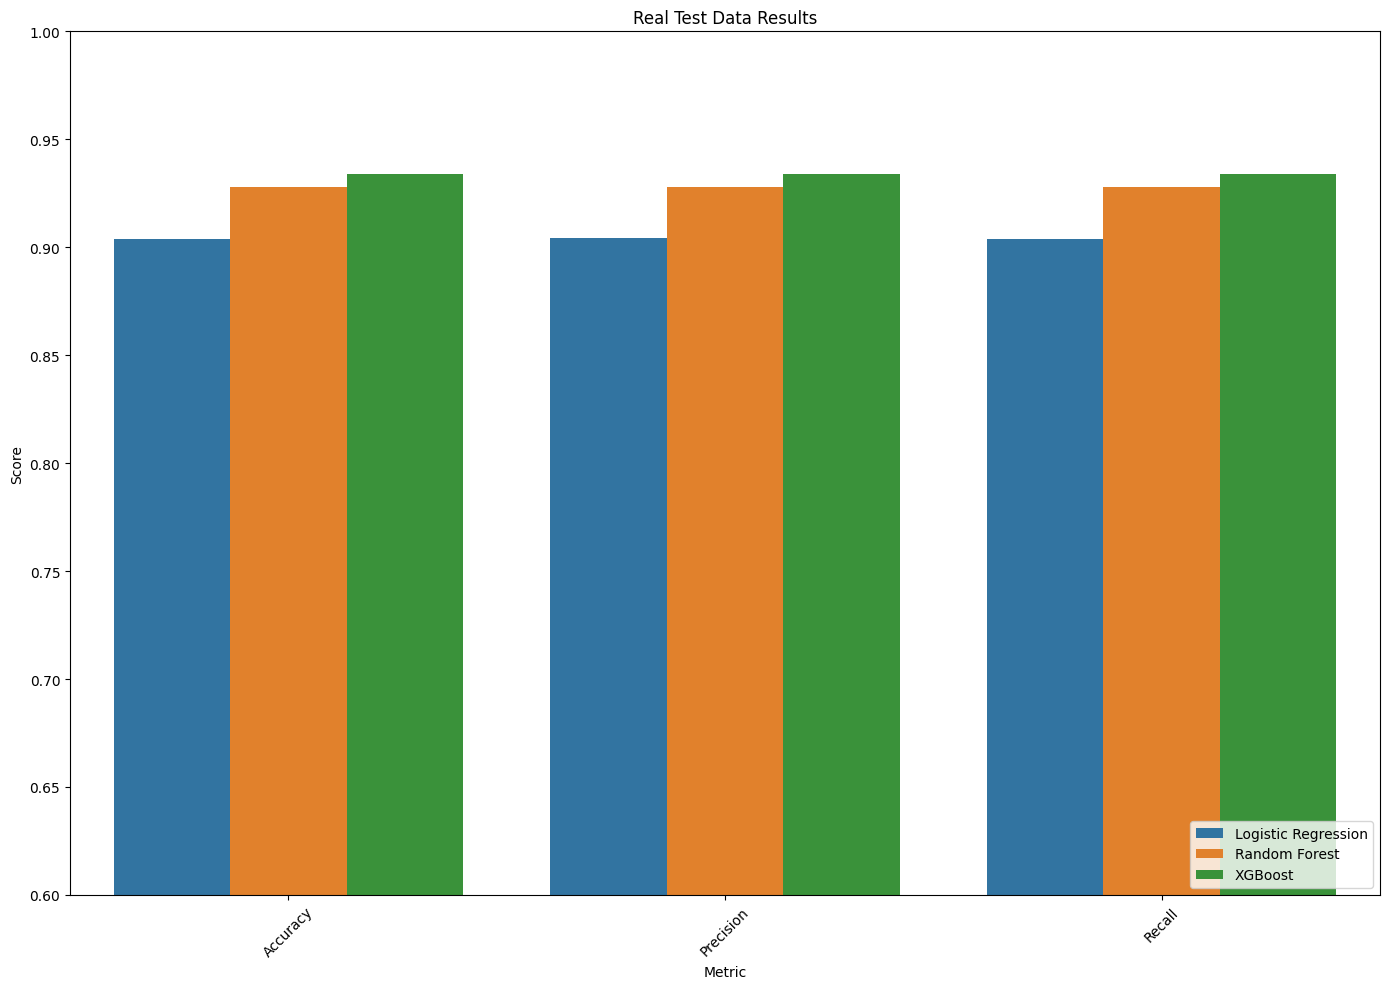

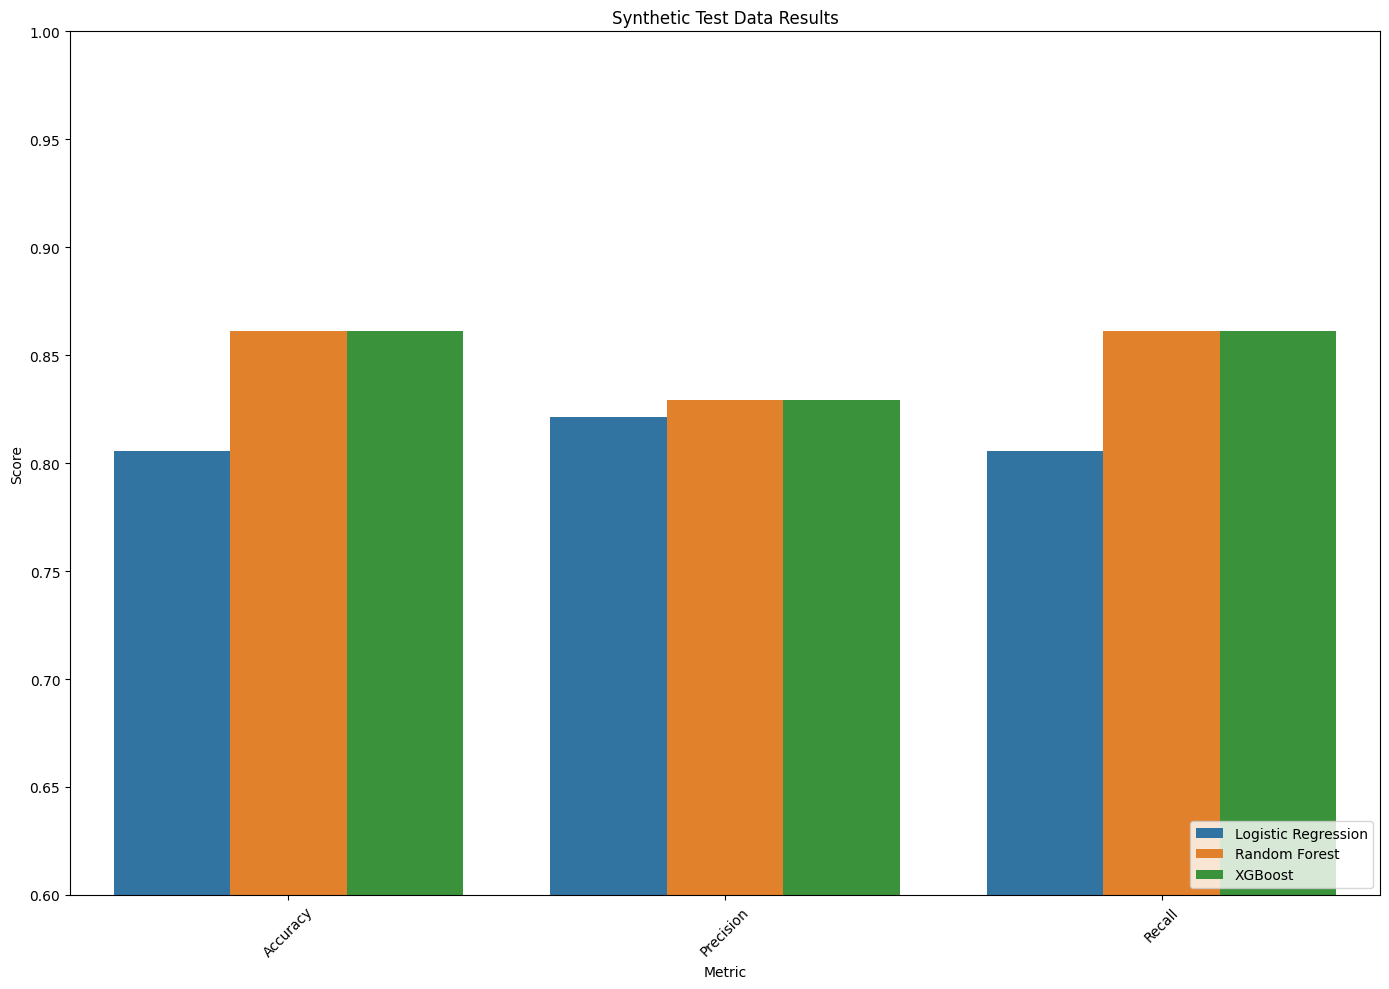

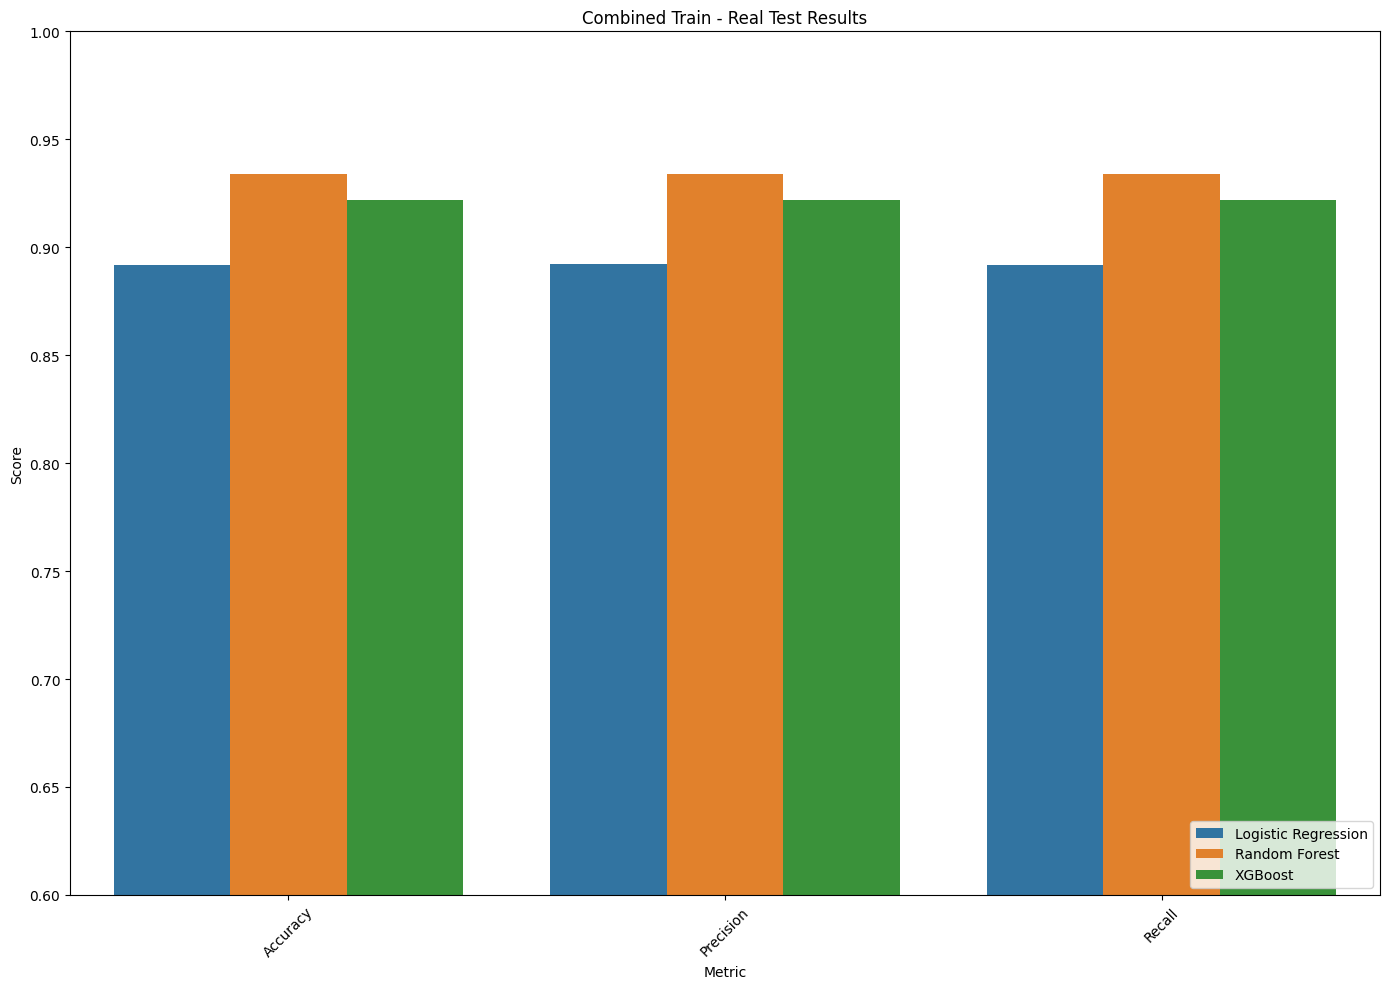

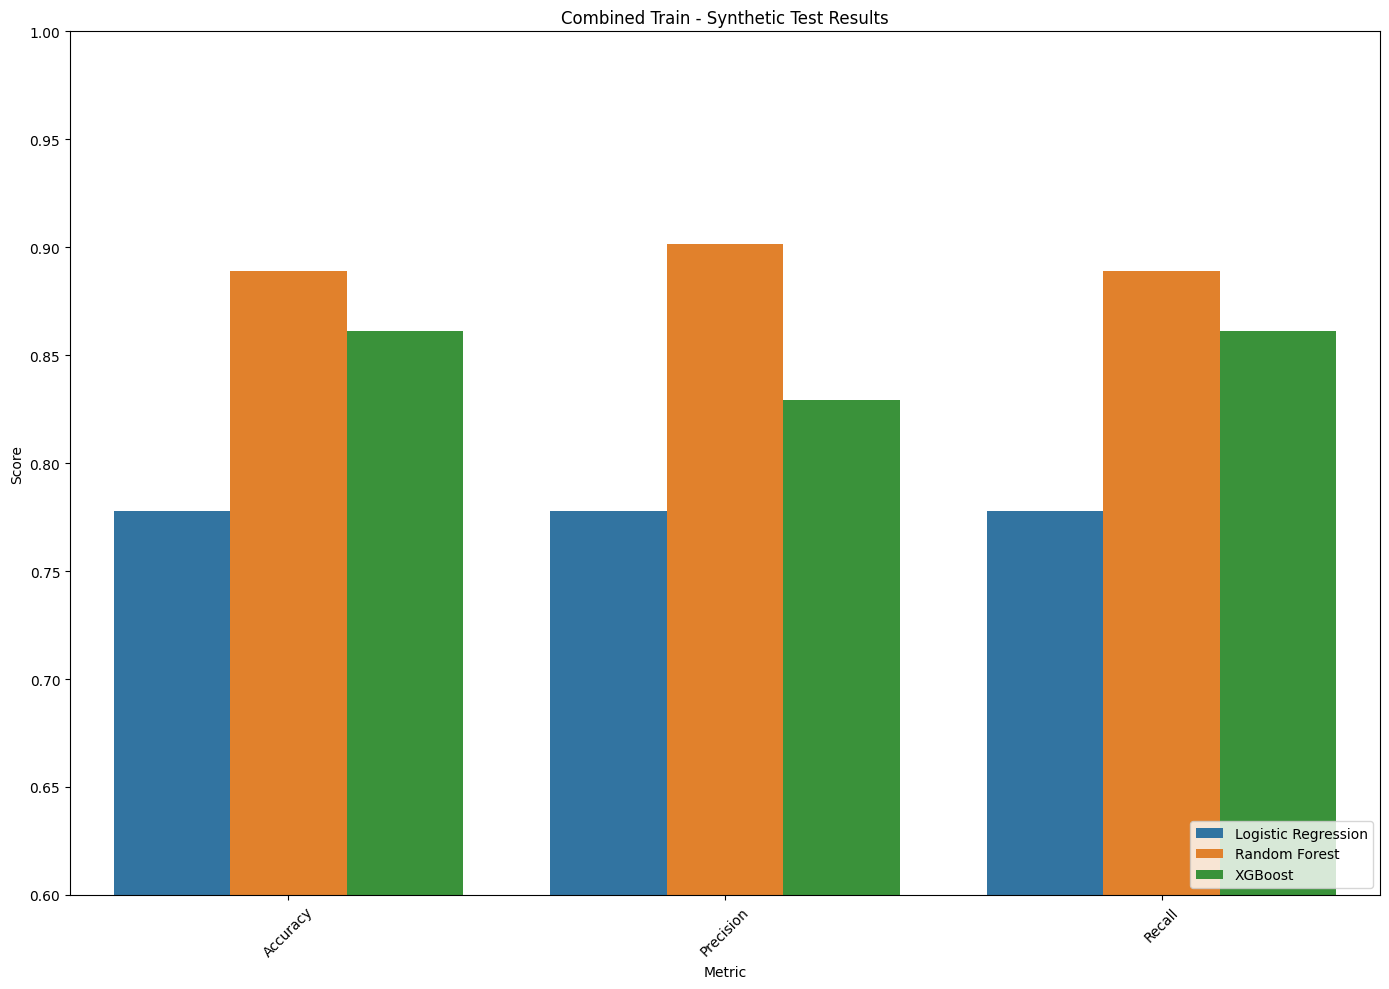

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results_comparison(results, title):
    # Chuyển đổi DataFrame thành dạng dài (long format)
    results_melted = results.melt(id_vars=["Model", "Dataset"], value_vars=["Accuracy", "Precision", "Recall"],
                                  var_name="Metric", value_name="Score")
    
    
    plt.figure(figsize=(14, 10))
    

    sns.barplot(x="Metric", y="Score", hue="Model", data=results_melted)
    plt.title(f"{title}")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.ylim(0.6, 1.0)
    
    plt.tight_layout()
    plt.show()


plot_results_comparison(real_results, "Real Test Data Results")
plot_results_comparison(syn_results, "Synthetic Test Data Results")
plot_results_comparison(combined_results_real, "Combined Train - Real Test Results")
plot_results_comparison(combined_results_syn, "Combined Train - Synthetic Test Results")


### Chạy model với CL

In [150]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Khởi tạo các model
models_base = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42, solver='lbfgs', C=1.0, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# Tạo replay buffer
class ReplayBuffer:
    def __init__(self, max_size=1000):
        self.buffer = []
        self.max_size = max_size
    
    def add(self, data):
        self.buffer.append(data)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(0)
    
    def sample(self, batch_size):
        return shuffle(self.buffer)[:batch_size]

# Huấn luyện và đánh giá model với continual learning
def train_and_evaluate(models, X_train, y_train, X_test, y_test, label, batch_size=32, replay_buffer_size=1000):
    results = []
    for name, model in models.items():
        start_time = time.time()  # Thời gian bắt đầu huấn luyện
        
        # Huấn luyện trên toàn bộ tập dữ liệu X_train đầu tiên
        model.fit(X_train, y_train)
        
        # Tạo replay buffer
        replay_buffer = ReplayBuffer(max_size=replay_buffer_size)
        
        # Thêm toàn bộ tập dữ liệu vào replay buffer sau khi huấn luyện
        replay_buffer.add((X_train, y_train))
        
        # Tiến hành huấn luyện tiếp tục (continual learning) sau khi huấn luyện ban đầu
        for i in range(0, len(X_train), batch_size):
            # Lấy một batch dữ liệu
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Thêm vào replay buffer
            replay_buffer.add((X_batch, y_batch))
            
            # Lấy mẫu ngẫu nhiên từ replay buffer
            X_replay, y_replay = zip(*replay_buffer.sample(batch_size))
            X_replay = np.concatenate(X_replay, axis=0)
            y_replay = np.concatenate(y_replay, axis=0)
            
            # Huấn luyện mô hình trên batch cộng với dữ liệu replay
            model.fit(X_replay, y_replay)
        
        end_time = time.time()  # Thời gian kết thúc huấn luyện
        training_time = end_time - start_time  # Thời gian huấn luyện
        
        # Đánh giá mô hình
        predictions = model.predict(X_test)
        report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
        metrics = {
            "Model": name,
            "Dataset": label,
            "Accuracy": report["accuracy"],
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "Training Time (seconds)": training_time
        }
        results.append(metrics)
    
    return pd.DataFrame(results)

real_results = train_and_evaluate(models_base, X_real_train, y_real_train, X_real_test, y_real_test, "Real", batch_size=32, replay_buffer_size=1000)
syn_results = train_and_evaluate(models_base, X_real_train, y_real_train, X_syn_test, y_syn_test, "Synthetic", batch_size=32, replay_buffer_size=1000)

print("\nResults on Real Test Data:\n", real_results)
print("\nResults on Synthetic Test Data:\n", syn_results)

c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Results on Real Test Data:
                  Model Dataset  Accuracy  Precision    Recall  \
0  Logistic Regression    Real  0.909639   0.910877  0.909639   
1        Random Forest    Real  0.939759   0.939759  0.939759   
2              XGBoost    Real  0.939759   0.939945  0.939759   

   Training Time (seconds)  
0                 0.446686  
1                 6.559315  
2                 2.742459  

Results on Synthetic Test Data:
                  Model    Dataset  Accuracy  Precision    Recall  \
0  Logistic Regression  Synthetic  0.805556   0.821296  0.805556   
1        Random Forest  Synthetic  0.861111   0.829248  0.861111   
2              XGBoost  Synthetic  0.833333   0.803030  0.833333   

   Training Time (seconds)  
0                 0.466273  
1                 7.347738  
2                 2.141400  


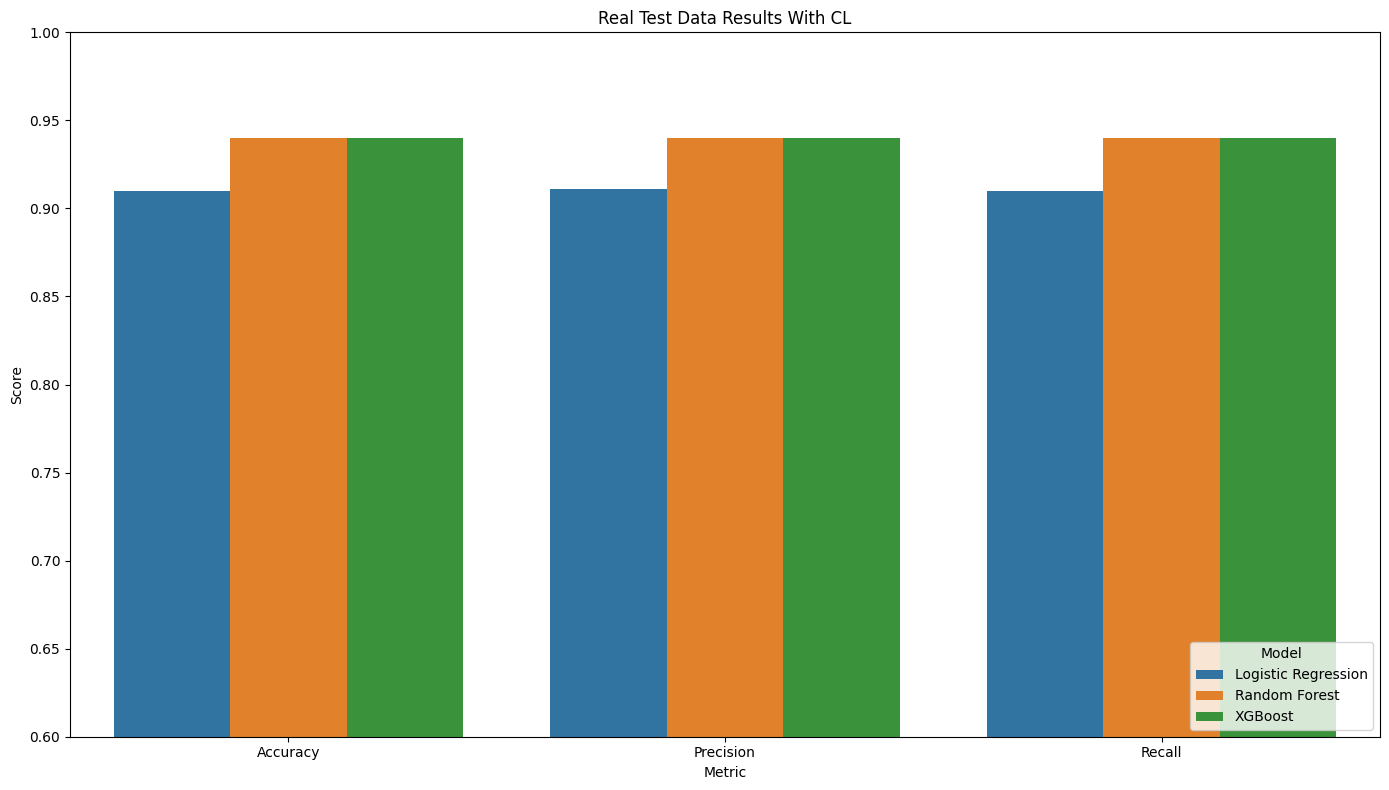

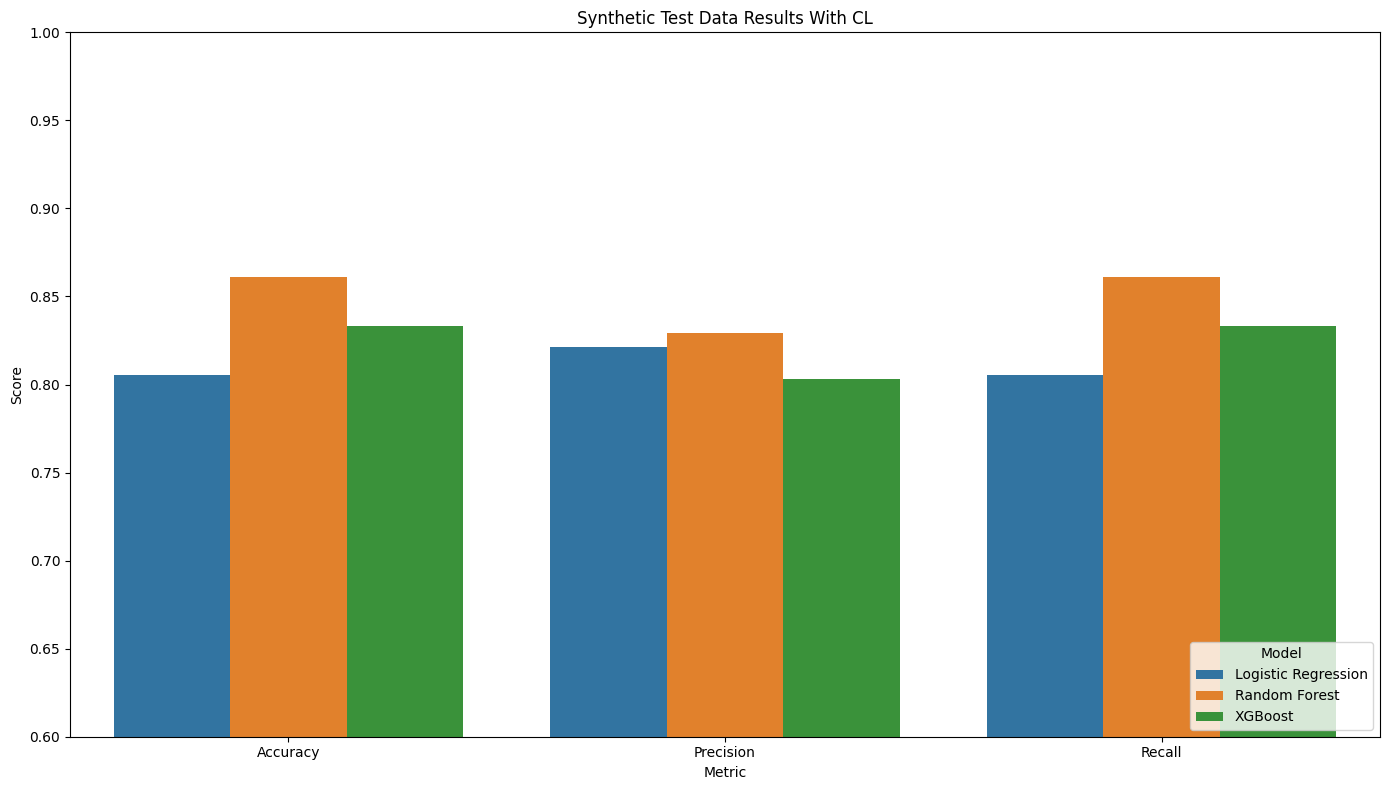

In [152]:
# Hàm vẽ biểu đồ cho các kết quả
def plot_results(results, title):
    # Chuyển đổi DataFrame thành dạng dài (long format)
    results_melted = results.melt(id_vars=["Model", "Dataset"], value_vars=["Accuracy", "Precision", "Recall"],
                                  var_name="Metric", value_name="Score")
    
    # Vẽ biểu đồ với seaborn
    plt.figure(figsize=(14, 8))
    sns.barplot(x="Metric", y="Score", hue="Model", data=results_melted, errorbar=None)
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.legend(title="Model", loc='lower right')
    plt.ylim(0.6, 1.0)
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ cho các kết quả
plot_results(real_results, "Real Test Data Results With CL")
plot_results(syn_results, "Synthetic Test Data Results With CL")
